In [1]:
import numpy as np
from src.cost import LogCost
from src.cpop import CPOP
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

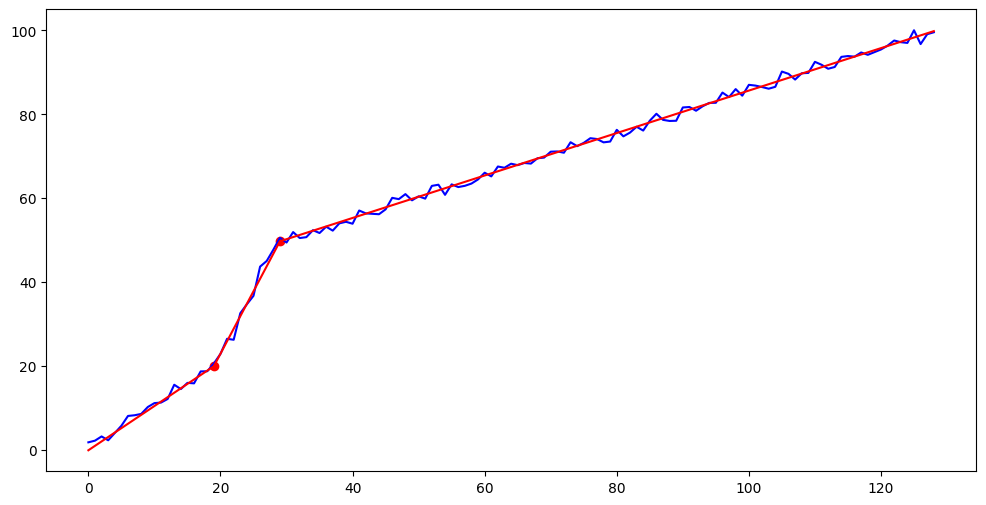

In [2]:
y = np.concatenate([np.arange(1, 20), np.arange(20, 50, 3), np.arange(50, 100, 0.5)])
y += np.random.randn(len(y))
h = LogCost(1)
sigma = 1
beta = 200

detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()

In [3]:
import pandas as pd
import json

df = pd.read_csv("../data/gdp.csv", skiprows=4)

In [4]:
sdf = df[df["Country Name"]=="Argentina"]

columns_years = [col for col in sdf.columns if col.isdigit()]
ts = sdf.loc[:, columns_years]

serie = ts.reset_index(drop=True).T
y = serie[0].to_numpy()

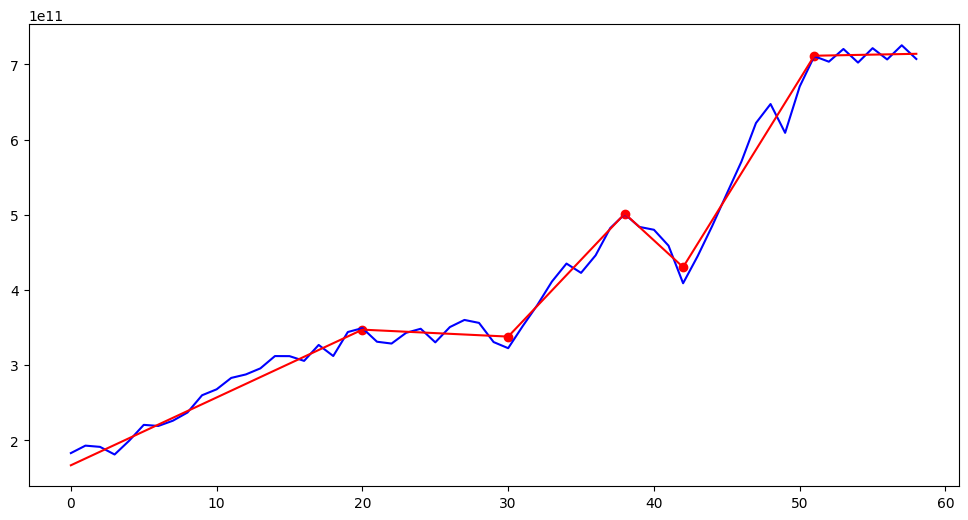

np.float64(2950.403602856342)

In [5]:
h = LogCost(1)
sigma = median_abs_deviation(serie[0].diff()[1:])
beta = 10

detector = CPOP(y, sigma, beta, h)
output = detector.run()
detector.compute_approx_and_plot()
detector.BIC()

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


Beta for min BIC: 3.0
BIC: 2940.479295550103


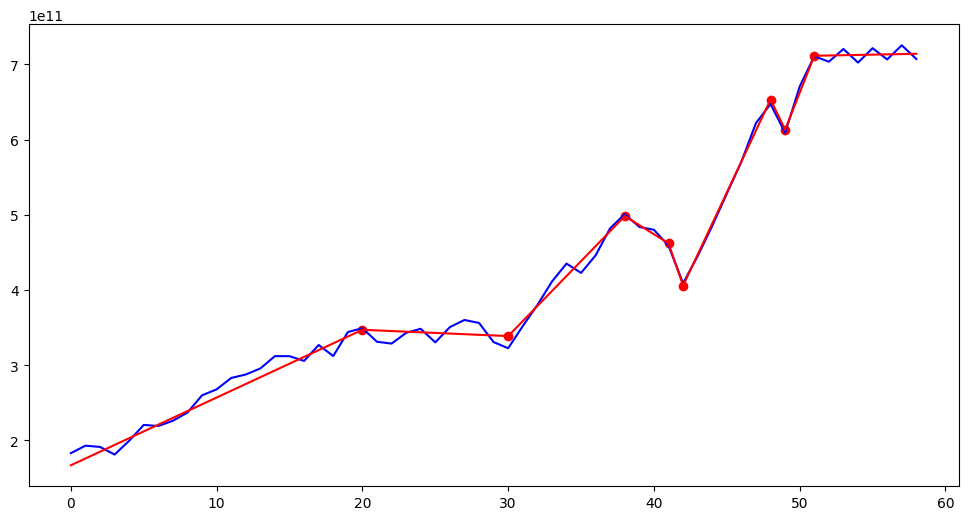

In [6]:
detector.compute_max_bic(beta_range=np.linspace(0.5, 20, 40))

In [7]:
with open("../data/gdp_iran.json", "r") as file:
    data = json.load(file)

In [8]:
gdp_iran = np.array(data["series"][0]["raw"])
sigma = median_abs_deviation(np.diff(gdp_iran))


100%|██████████| 39/39 [00:02<00:00, 16.76it/s]


Beta for min BIC: 4.092105263157896
BIC: 3966.224202072278


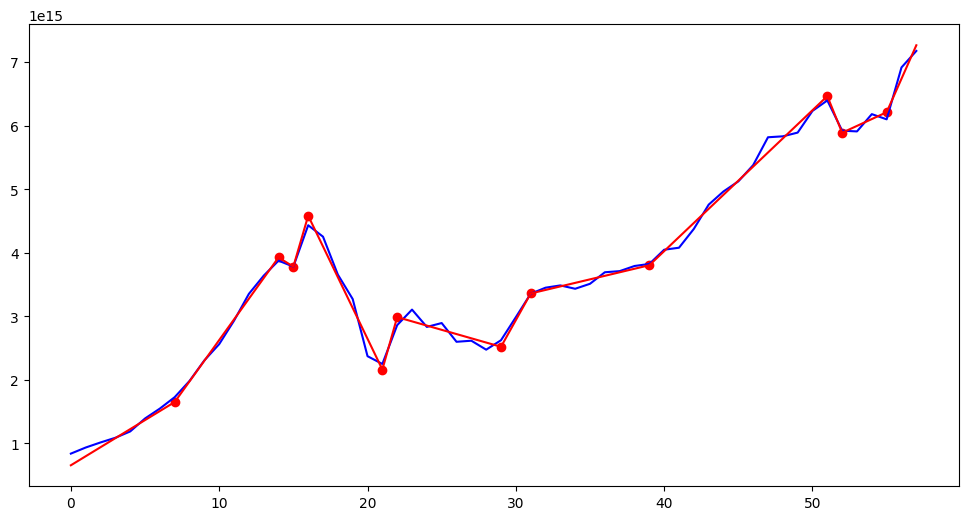

In [9]:
h = LogCost(1)

beta = 10

detector = CPOP(gdp_iran, sigma, beta, h)
detector.compute_max_bic()

In [10]:
from src.pelt import PELT
from src.cost import cost_L2

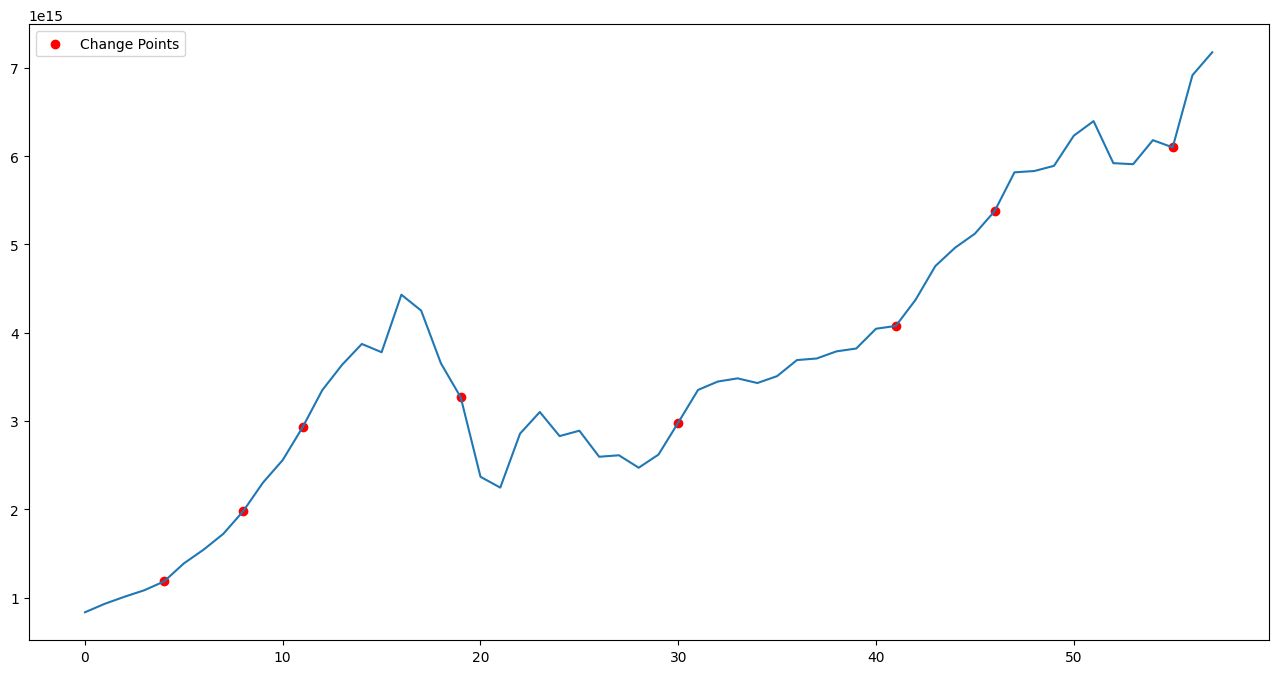

In [11]:
pelt = PELT(gdp_iran, cost_L2, 8)
pelt.run()
pelt.show_changepoints(8)

100%|██████████| 57/57 [00:00<00:00, 2178.66it/s]


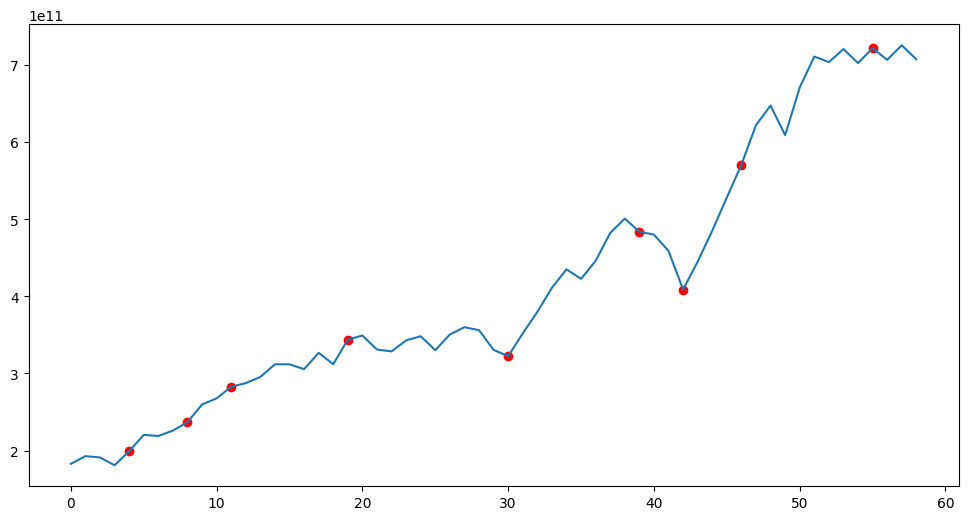

In [12]:
from tqdm import tqdm 
def OP_CPD(x, cost, beta):
    # Initialization 
    n = len(x)
    T = np.empty(n, dtype=int) 
    T[0] = 0 
    F = np.empty(n+1)
    F[0] = -beta 
    F[1] = cost(x[0])

    # Compute T and F
    for t in tqdm(range(2, n+1)):
        cost_array = np.empty(t)
        for s in range(t):
            cost_array[s] = F[s] + cost(x[s:t]) + beta 
        T[t-1] = np.argmin(cost_array)  # Last optimal change point of (x_1, ..., x_t) ==> it's a position, not an index here!
        F[t] = cost_array[T[t-1]]       # Cost for choosing optimal change points of (x_1, ..., x_t) 
    
    # Compute the optimal change points 
    CP = [T[-1]]
    while CP[0] != 0:        
        CP.insert(0, T[CP[0]-1])
    CP = np.array(CP[1:])
    CP -= 1  # We turn the positions into indices 
    
    # Return CP
    return CP

plt.figure(figsize=(12, 6))
plt.plot(y)
output = OP_CPD(gdp_iran/sigma, cost_L2, 30)
plt.scatter(output, y[output], c="r")